## Background

In this notebook, I'll work through the following prompt given in the "Further Research" of Chapter 8 (Collaborative Filtering):

> Create a model for MovieLens that works with cross-entropy loss, and compare it to the model in this chapter.

## Visual Inspection

I'll start by visually inspecting the `DotProductBias` model from the chapter that outputs one prediction and a `DotProductBiasCE` model that I've written to output 5 predictions (so that it works with Cross Entropy loss).

![Visual inspection of `DotProductBias` Modules](1.png)

## Creating `DataLoaders`

Since I want to use Cross Entropy loss, I'll need to specify that the outputs (or targets) are discrete categories and not continuous numbers. To do this, I'll use `TabularDataLoaders`.

In [1]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

In [2]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None, names=['user', 'movie', 'rating', 'timestamp'])
movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1', usecols=(0,1), names=('movie', 'title'), header=None)
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [3]:
dls = TabularDataLoaders.from_df(
    ratings[['user', 'title', 'rating']],
    procs=[Categorify],
    cat_names=['user','title'],
    y_names=['rating'],
    y_block=CategoryBlock)

`TabularDataLoaders` will provide three elements for each training item: the `cat`egorical inputs, the `cont`inuous inputs and the outputs (or targets, or dependent variable):

In [4]:
b = dls.one_batch()
len(b), b[0].shape, b[1].shape, b[2].shape

(3, torch.Size([64, 2]), torch.Size([64, 0]), torch.Size([64, 1]))

This is important to note before I create the model since the forward pass will receive two values: `x_cat` (categorical inputs) and `x_cont` (continuous inputs).

The `TabularDataLoaders` also has a vocabulary---the five possible values for the dependent variable (1 through 5).

In [6]:
dls.vocab

[1, 2, 3, 4, 5]

## Creating the New Model

I'll start by creating the original `DotProductBias` model for reference:

In [28]:
class DotProductBias(Module):
  def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
    self.user_factors = Embedding(n_users, n_factors)
    self.user_bias = Embedding(n_users, 1)
    self.movie_factors = Embedding(n_movies, n_factors)
    self.movie_bias = Embedding(n_movies, 1)
    self.y_range = y_range

  def forward(self, x):
    users = self.user_factors(x[:,0])
    movies = self.movie_factors(x[:,1])
    res = (users * movies).sum(dim=1, keepdim=True)
    res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
    return sigmoid_range(res, *self.y_range)

The biggest change in the behavior of the model, to allow the usage of Cross Entropy loss, is to make it output 5 activations instead of 1. I'll do so by passing the dot product through an `nn.Linear` layer that projects that value into 5 dimensions (one for each rating 1-5) in the `forward` pass.

The second change in the model behavior is to allow two inputs in the `forward` pass: `x_cat` for categorical variables and `x_cont` for continuous variables, which is how `TabularDataLoaders` prepares the data. In the case of the MovieLens 100k subset, there are no continuous variables. The only variables of interest are the categoricals `users` and `movies`, one column for each in the input `x_cat`.

In [20]:
class DotProductBiasCE(Module):
  def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
    self.user_factors = Embedding(n_users, n_factors)
    self.user_bias = Embedding(n_users, 1)
    self.movie_factors = Embedding(n_movies, n_factors)
    self.movie_bias = Embedding(n_movies, 1)
    self.y_range = y_range
    self.linear = nn.Linear(1, 5)

  def forward(self, x_cat, x_cont):
    x = x_cat
    users = self.user_factors(x[:,0])
    movies = self.movie_factors(x[:,1])
    res = (users * movies).sum(dim=1, keepdim=True)
    res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
    res = sigmoid_range(res, *self.y_range)
    return self.linear(res)

In [21]:
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])

n_users, n_movies

(944, 1665)

In [22]:
model = DotProductBiasCE(n_users, n_movies, 50)

In [27]:
model(x_cat=b[0], x_cont=b[1]).shape

torch.Size([64, 5])

## Training the Model

I'll use the same hyperparameters (5 epochs, LR=5e-3 and weight decay of 0.1) as the best training run in the text. Of course, this is a different model so these values may not be optimal.

In [72]:
model = DotProductBiasCE(n_users, n_movies, n_factors=50)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.426626,1.445451,0.337150,00:15
1,1.281385,1.425528,0.339900,00:15
2,1.171326,1.431534,0.364500,00:16
3,1.105676,1.438475,0.361650,00:16
4,1.127306,1.438119,0.363450,00:14


The model's not great (although it's better than guessing ratings randomly which would have an accuracy of 20%) and it's difficult to compare it with the `DotProductBias` model since that model only measured RMSE and not accuracy.

I'll take a look at the predictions and see how they compare to the actual ratings.

Looking at the confusion matrix below, here are some observations:

- The model did not predict any `5`s.
- The best predicted rating was a `4` (with 4327/6692, or 65% correct predictions).
- Most of the model's predictions are `3`s or `4`s.

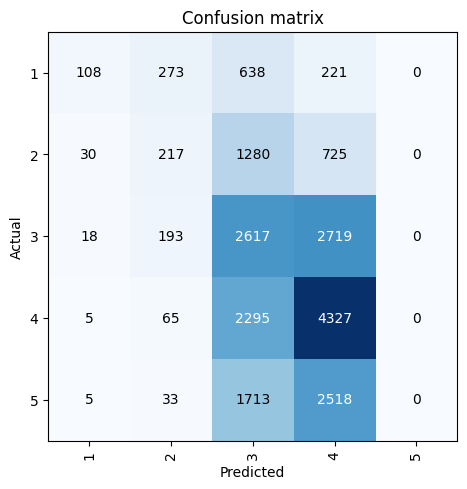

In [89]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Improving the Model

Looking at these results, I'm starting to think that using `sigmoid_range` in this model is causing it to predict values in the middle of the range (2-4) and making it harder for it to predict ratings that are at the edges (1 and 5). I'll remove `y_range` and `sigmoid_range` from the model and train it again to see if it makes a difference.

In [94]:
class DotProductBiasCE(Module):
  def __init__(self, n_users, n_movies, n_factors):
    self.user_factors = Embedding(n_users, n_factors)
    self.user_bias = Embedding(n_users, 1)
    self.movie_factors = Embedding(n_movies, n_factors)
    self.movie_bias = Embedding(n_movies, 1)
    self.linear = nn.Linear(1, 5)

  def forward(self, x_cat, x_cont):
    x = x_cat
    users = self.user_factors(x[:,0])
    movies = self.movie_factors(x[:,1])
    res = (users * movies).sum(dim=1, keepdim=True)
    res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
    return self.linear(res)

In [95]:
model = DotProductBiasCE(n_users, n_movies, n_factors=50)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.392305,1.434367,0.353000,00:14
1,1.238957,1.465206,0.349450,00:15
2,1.122690,1.507049,0.354700,00:15
3,1.053334,1.523502,0.361450,00:14
4,1.038323,1.527965,0.364200,00:15


The resulting accuracy is about the same as before. Let's look at the confusion matrix:

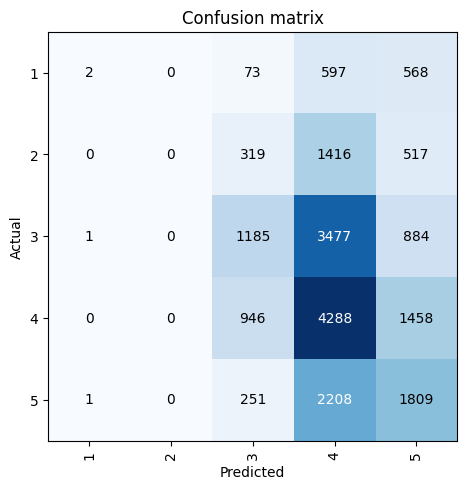

In [96]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The model is now predicting `5`s. Although now it's not predicting any `1`s or `2`s! I'll see if there's a better learning rate for this architecture:

SuggestedLRs(valley=0.005248074419796467)

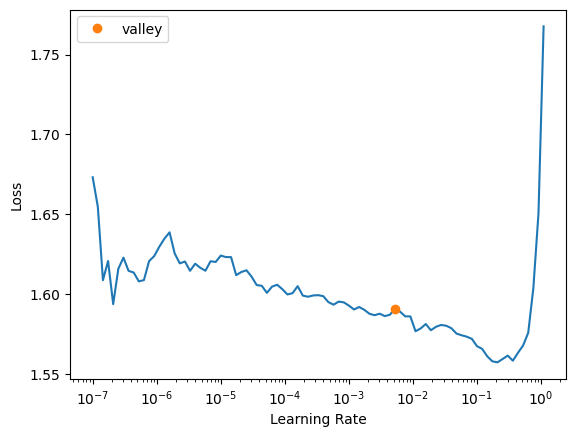

In [99]:
model = DotProductBiasCE(n_users, n_movies, n_factors=50)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

learn.lr_find()

I'll try a learning rate of 0.1, which is two orders of magnitude larger than 5e-3.

In [100]:
model = DotProductBiasCE(n_users, n_movies, n_factors=50)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

learn.fit_one_cycle(5, 0.1, wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.402151,1.460189,0.337900,00:14
1,1.410952,1.438032,0.348000,00:13
2,1.353970,1.407190,0.370100,00:13
3,1.232812,1.351564,0.401050,00:13
4,1.070482,1.324203,0.415400,00:14


The higher learning rate improved the accuracy by about 5%. Looking at the confusion matrix, here are some observations---the model is predicting `1`s and `2`s better than before and the rating of `4` is still the best predicted rating (62% of all actual `4`s are predicted as `4`s). However, the model is still predominantly predicting `3`s and `4`s.

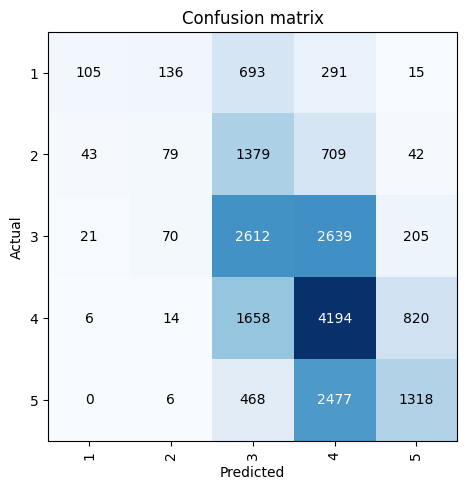

In [101]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

I'll also check that fastai is automatically applying softmax so that the final activations add up to 1.00:

In [104]:
probs, _ = learn.get_preds(dl=dls.valid)
probs.sum(dim=1)

tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000])

In [105]:
probs.sum(dim=1).sum() # should equal 20k

tensor(20000.)

## Final Thoughts

I'll recap this exercise by displaying the visual comparison between `DotProductBias` and the final `DotProductBiasCE` (without `y_range` and `sigmoid_range`).

![Visual inspection of `DotProductBias` Modules](2.png)

My main takeaway from this exercise is that what may work for one architecture may not necessarily work for another. In this example when passing the dot product through the sigmoid function before passing it through a linear layer, the model did not predict any `5`s even though there were many actual `5` ratings in the dataset.

Another takeaway is that I wasn't able to compare two models that used different metrics (RMSE vs. accuracy). So I'm limited in my ability to say which model performed "better". I asked Claude for ideas on how to compare these two models and it came up with the following:

- Convert RMSE to accuracy
  - Round continuous predictions to nearest integer
  - Calculate accuracy using rounded predictions
  - Compare this accuracy to the categorical model
- Convert accuracy to RMSE-like metric:
  - Calculate average error for categorical predictions
  - Compare this to the continuous model's RMSE
- Use normalized metrics:
  - Normalize RMSE: RMSE / (max_rating - min_rating)
  - Normalize accuracy: (accuracy - random_guess_accuracy) / (1 - random_guess_accuracy)
  - Compare normalized values


I'll poke around online (I've also asked about this on Twitter and the fastai forums) to see if there are thoughts on or examples of such comparisons, and then follow up with some exploration in a future blog post.

I hope you enjoyed this exercise! Follow me on Twitter [@vishal_learner](https://x.com/vishal_learner/status/1807898740747034799).